## An Analysis of Uber Pickups in New York City
**By Enrique Sanchez**

**Imports**

Before we get started, let's import all the required packages/libraries that we will need for this analysis.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import datashader as ds
import colorcet as cc
import folium

from collections import defaultdict, OrderedDict
from folium.plugins import HeatMapWithTime
from datetime import datetime

Let's also set some global plot settings.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,10)

## The Data

For this analysis, we will be focusing on Uber pickups throughout New York City for the months of April through September 2014. The data is available across 6 CSV files, each file containing data for 1 month. The following variables are available for each pickup:

- `Date/Time`: The Date and Time of the Uber pickup
- `Lat`: The latitude of the pickup location
- `Lon`: The longitude of the pickup location
- `Base`: The TLC base company code affiliated with the Uber pickup

Let's now read in each file and join them into a single data frame `pickups`.

In [3]:
# Available months
months = ['apr','may', 'jun', 'jul', 'aug', 'sep']

# Shared file path
raw_fp = '../input/uber-pickups-in-new-york-city/uber-raw-data-{}14.csv'

# Read and concatenate pickup data
pickups = pd.DataFrame()
for month in months:
    month_df = pd.read_csv(raw_fp.format(month))
    pickups = pd.concat([pickups, month_df])
    
pickups.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


## Data Wrangling

Notice that a lot of information can be extracted from the `Date/Time` column -- we can produce separate `Month`, `Day`, and `Time` variables. 

**Note**: Although we can also produce a `Year` column, it does not provide us with any additional information as all pickups occurred in 2014.

In [4]:
# Disaggregate 'Date/Time' column
pickups['Date/Time'] = pd.to_datetime(pickups['Date/Time'])

pickups['Month'] = pickups['Date/Time'].dt.month
pickups['Day'] = pickups['Date/Time'].dt.day
pickups['Time'] = pickups['Date/Time'].dt.time

pickups.head()

,Date/Time,Lat,Lon,Base,Month,Day,Time
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,00:11:00
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,00:17:00
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,00:21:00
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,00:28:00
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,00:33:00


It would also be useful to know the day of the week in which each pickup occurred. Additionally, the `Time` column is quite granular, let's also create an `Hour` column.

In [5]:
# Day of the week
pickups['Weekday'] = pickups['Date/Time'].dt.dayofweek

# Hour
pickups['Hour'] = pickups['Date/Time'].dt.hour

pickups.head()

,Date/Time,Lat,Lon,Base,Month,Day,Time,Weekday,Hour
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,4,1,00:11:00,1,0
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,4,1,00:17:00,1,0
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512,4,1,00:21:00,1,0
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512,4,1,00:28:00,1,0
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512,4,1,00:33:00,1,0


Now that we have all the needed variables, let's map some of these variable's values to make the data more understandable.

In [6]:
# Map month
month_map = {
    4: 'April',
    5: 'May',
    6: 'June', 
    7: 'July',
    8: 'August',
    9: 'September'
}
pickups['Month'] = pickups['Month'].replace(month_map)

# Map weekday
weekday_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday',
    6: 'Sunday'
}
pickups['Weekday'] = pickups['Weekday'].replace(weekday_map)

final_columns = [
    'Base', 'Lat', 'Lon', 'Month', 
    'Day', 'Weekday', 'Hour']
pickups = pickups[final_columns]
pickups.head()

,Base,Lat,Lon,Month,Day,Weekday,Hour
0,B02512,40.7690,-73.9549,April,1,Tuesday,0
1,B02512,40.7267,-74.0345,April,1,Tuesday,0
2,B02512,40.7316,-73.9873,April,1,Tuesday,0
3,B02512,40.7588,-73.9776,April,1,Tuesday,0
4,B02512,40.7594,-73.9722,April,1,Tuesday,0


## Data Quality Check

Before we jump into analyzing Uber pickups, let's determine whether there are any issues with the data set.

**Missing Values**

In [7]:
num_missing = pickups.isnull().sum().sum()
print('Number of missing values: {}'.format(num_missing))

Number of missing values: 0


**Value Ranges & Categories**

In [8]:
# Latitude must be between -90 and 90
lat_check = pickups['Lat'].between(-90, 90, inclusive=True).all()
assert lat_check, 'Invalid latitude values exist'

# Longitude must be between -180 and 180
lon_check = pickups['Lon'].between(-180, 180, inclusive=True).all()
assert lon_check, 'Invalid longitude values exist'

# Hour must be between 0 and 23
hour_check = pickups['Hour'].between(0, 23, inclusive=True).all()
assert hour_check, 'Invalid hour values exist'

# Day must be between 1 and 31
day_check = pickups['Day'].between(1, 31, inclusive=True).all()
assert day_check, 'Invalid day values exist'

print('All value ranges valid.')

All value ranges valid.


In [9]:
# Months must be between 4 and 9
month_check = not set(pickups['Month']).difference(month_map.values())
assert month_check, 'Invalid Month values'

weekday_check = not set(pickups['Weekday']).difference(weekday_map.values())
assert weekday_check, 'Invalid Weekday values'

print('Value categories valid.')

Value categories valid.


**Duplicate Pickups**

In [10]:
duplicate_pickups = pickups[pickups.duplicated(keep=False)]
duplicate_pickups

,Base,Lat,Lon,Month,Day,Weekday,Hour
43,B02512,40.7430,-74.0301,April,1,Tuesday,5
44,B02512,40.7430,-74.0301,April,1,Tuesday,5
127,B02512,40.7805,-73.9481,April,1,Tuesday,7
128,B02512,40.7805,-73.9481,April,1,Tuesday,7
184,B02512,40.7620,-73.9787,April,1,Tuesday,8
...,...,...,...,...,...,...,...
1028065,B02764,40.7714,-73.9502,September,30,Tuesday,22
1028094,B02764,40.7277,-73.9893,September,30,Tuesday,22
1028095,B02764,40.7277,-73.9893,September,30,Tuesday,22
1028099,B02764,40.7212,-74.0048,September,30,Tuesday,22


Duplicate pickups do exist in the data set. Additional checks were made to check if duplicates occurred only for certain bases, dates, times, or locations but there does not seem to be any consistent trend. 

Given that we do not know the accuracy of a pickup's Latitude/Longitude or Time, these pickups may just have happened around the same time and around the same location. Therefore, for the sake of this analysis, we will assume that duplicate pickups are valid. 

Overall, the data looks to be in good shape -- let's proceed with the analysis.

## Exploratory Data Analysis

In [11]:
num_pickups = pickups.shape[0]
num_days = len(pickups[['Month', 'Day']].drop_duplicates())
daily_avg = np.round(num_pickups/num_days, 0)

stats_raw = 'Number of Pickups: {}\nNumber of Days: {}\nAvg Daily Pickups: {}'
print(stats_raw.format(num_pickups, num_days, daily_avg))

Number of Pickups: 4534327
Number of Days: 183
Avg Daily Pickups: 24778.0


According to the data, there were over **4.5 million** Uber pickups in New York City over the course of April through September 2014. This corresponds to **24,778** pickups every single day on average.

**Monthly Uber Pickups**

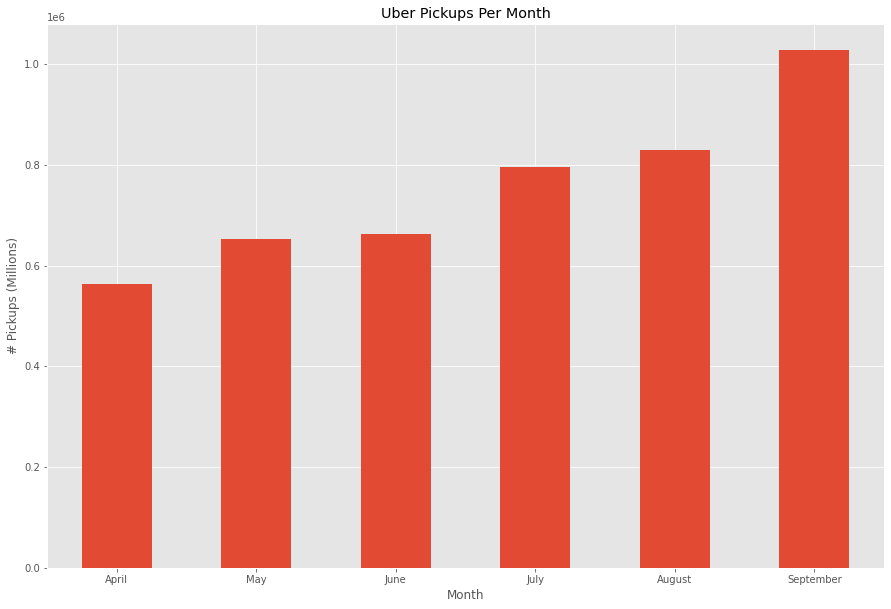

In [12]:
monthly_pickups = pickups['Month'].value_counts(ascending=True)[month_map.values()]

monthly_pickups.plot(kind='bar', rot=0)
plt.title('Uber Pickups Per Month')
plt.xlabel('Month')
plt.ylabel('# Pickups (Millions)');

According to the plot above, there was an increase in the number of Uber pickups from April to September 2014. Intuition may lead one to believe that Uber pickups would be greatest during Summer months, but this appears to not necessarily be the case.

Let's now break it down by weekday.

**Weekday Uber Pickups**

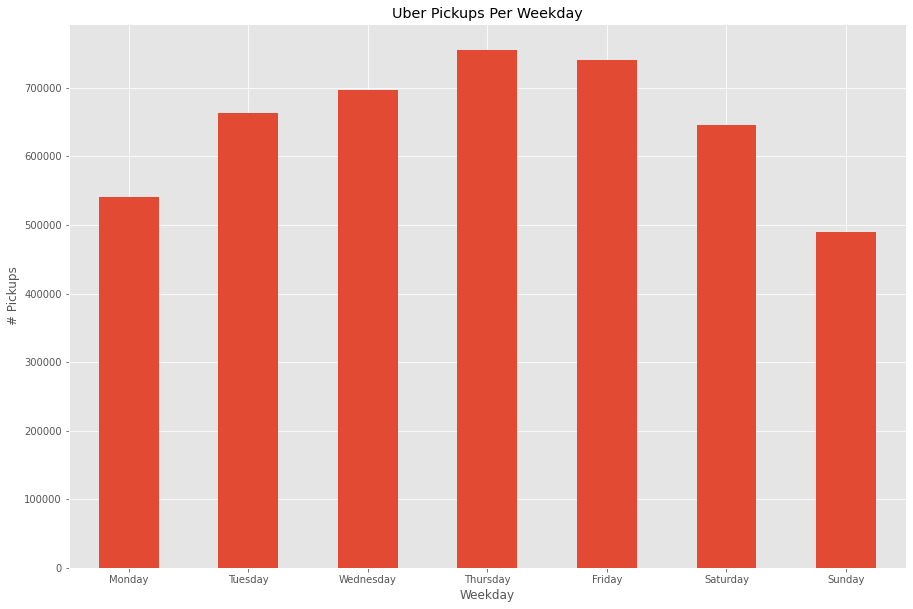

In [13]:
weekday_pickups = pickups['Weekday'].value_counts()[weekday_map.values()]

weekday_pickups.plot(kind='bar', rot=0)
plt.title('Uber Pickups Per Weekday')
plt.xlabel('Weekday')
plt.ylabel('# Pickups');

Pickups happened most during... Thursdays? Interesting... After Thursdays, Fridays closely follow. Even more interesting is the fact that more pickups occurred during Tuesdays and Wednesdays than on Saturdays or Sundays. Uber being used as a means to get to work during the week could be a possible explanation but, unfortunately, the purpose of these pickups is not available in the data.

However, this weekday trend may be different within months.

**Uber Pickups by Month and Weekday**

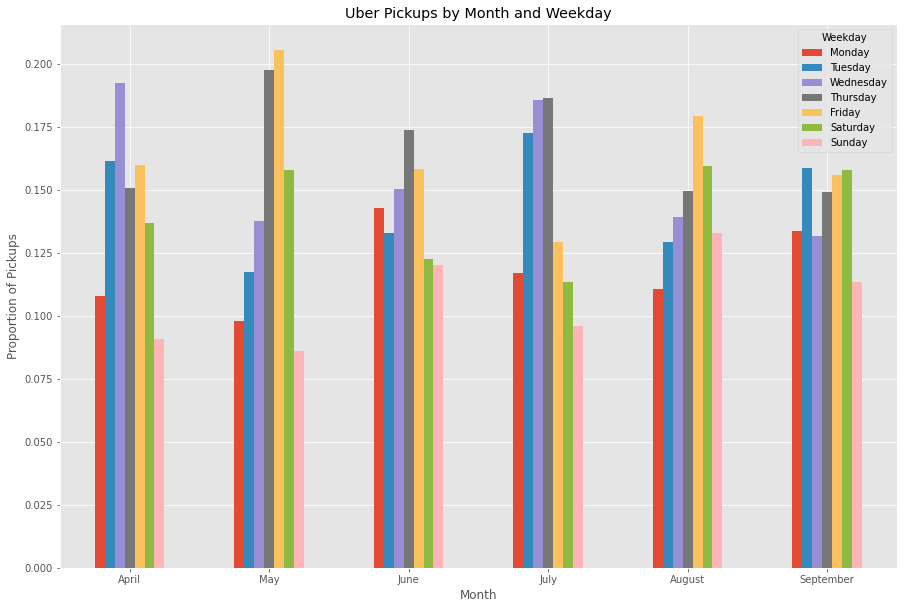

In [14]:
monthly_weekdays = pickups.groupby('Month')['Weekday'].value_counts().unstack()
monthly_weekdays_norm = monthly_weekdays.apply(lambda x: x/x.sum(), axis=1)

monthly_weekdays_norm.loc[month_map.values(),weekday_map.values()].plot(kind='bar', rot=0)
plt.ylabel('Proportion of Pickups')
plt.title('Uber Pickups by Month and Weekday');

Based on the plot above, some months (May, July, and August) see pickups consecutively increase Monday-Thursday/Friday and drop for later days of the week -- this is consistent with the overall trend we saw in the previous plot. Other months, like June and September, see much more variability across weekdays. Overall, weekday distributions do vary across months.

We have now analyzed the pickups by month and weekday. Let's take a look at the daily pickups.

**Daily Uber Pickups**

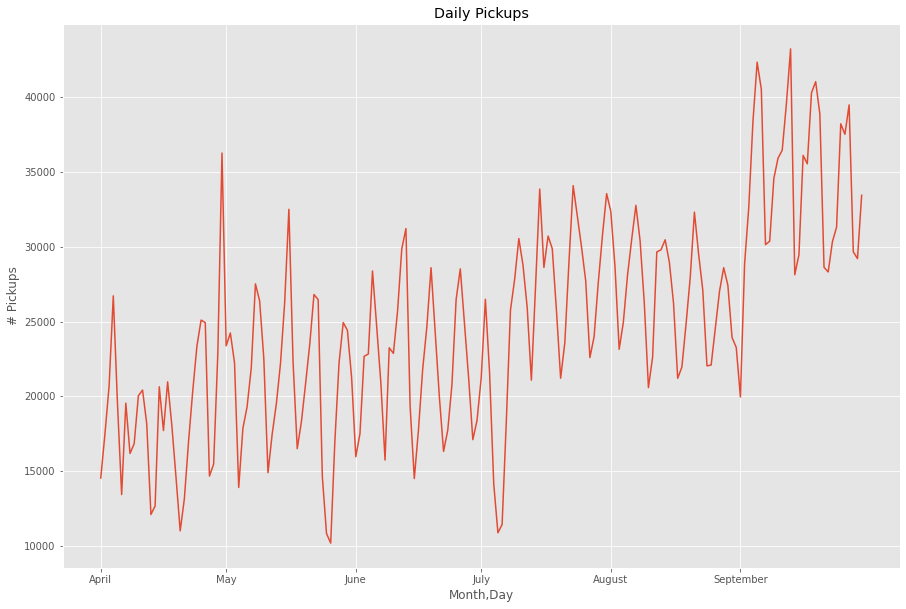

In [15]:
daily_pickups = pickups.groupby(['Month', 'Day'])['Hour'].count()[month_map.values()]
daily_pickups.plot(kind='line', rot=0)
month_starts = np.where(daily_pickups.reset_index(level=0, drop=True).index.get_loc(1))[0]
plt.xticks(ticks=month_starts, labels=month_map.values())
plt.ylabel('# Pickups')
plt.title('Daily Pickups');

As can be expected, there are about 4 peaks per month which correspond to the roughly 4-week cycles that happen every month. Some unexpected spikes do occur, most notably April 30th, and there is a big increase in daily pickups throughout September. We also see some "valleys" (a decline in pickups) May 24-26 and July 4-6. The second decline, July 4-6 is quite interesting as this corresponds to Independence Day weekend. One may expect elevated levels of Uber pickups to happened during such holidays, but this was not the case.

This Independence Day weekend observation may lead one to wonder how holidays affect Uber pickups. Therefore, let's focus on the following holidays:
- `Easter` (April 20, 2014)
- `Mother's Day` (May 11, 2014)
- `Memorial Day` (May 26, 2014)
- `Father's Day` (June 15, 2014)
- `Independence Day` (July 4, 2014)
- `Labor Day` (September 1, 2014)

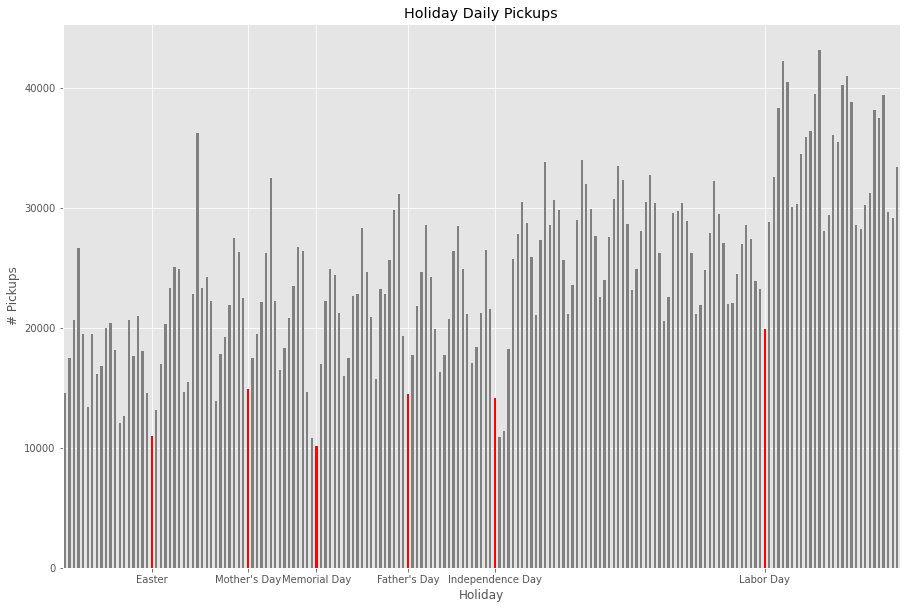

In [16]:
holidays = {
    "Easter": ('April', 20), # Sunday
    "Mother's Day": ('May', 11), # Sunday
    "Memorial Day": ('May', 26), # Monday
    "Father's Day": ('June', 15), # Sunday
    "Independence Day": ('July', 4), # Friday
    "Labor Day": ('September', 1) # Monday
}

holiday_starts = [daily_pickups.index.get_loc(hol) for hol in holidays.values()]
colors = ['grey' if x not in holiday_starts else 'red' for x in range(len(daily_pickups))]

daily_pickups.plot(kind='bar', color=colors, rot=0)
plt.xticks(ticks=holiday_starts, labels=holidays.keys())
plt.xlabel('Holiday')
plt.ylabel('# Pickups')
plt.title('Holiday Daily Pickups');

We do see a decline in the number of Uber pickups during holidays. Both of the "valleys" identified in the previous plot actually occurred during Memorial Day and Independence Day. 

Now, a simple conclusion from this would be that individuals don't use Uber as frequently during holidays. However, something else to consider is the availability of Uber drivers during holidays. Given that Uber drivers set their own work schedules, some may choose to not work during holidays. For such a case, a decline in Uber pickups during holidays may not be due to lack of demand but instead due to a lack of available Uber drivers. Additionally, many businesses are closed during holidays so individuals may just have no place to go!

Let's now move on to analyzing Uber pickups by different hours of the day.

**Hourly Uber Pickups**

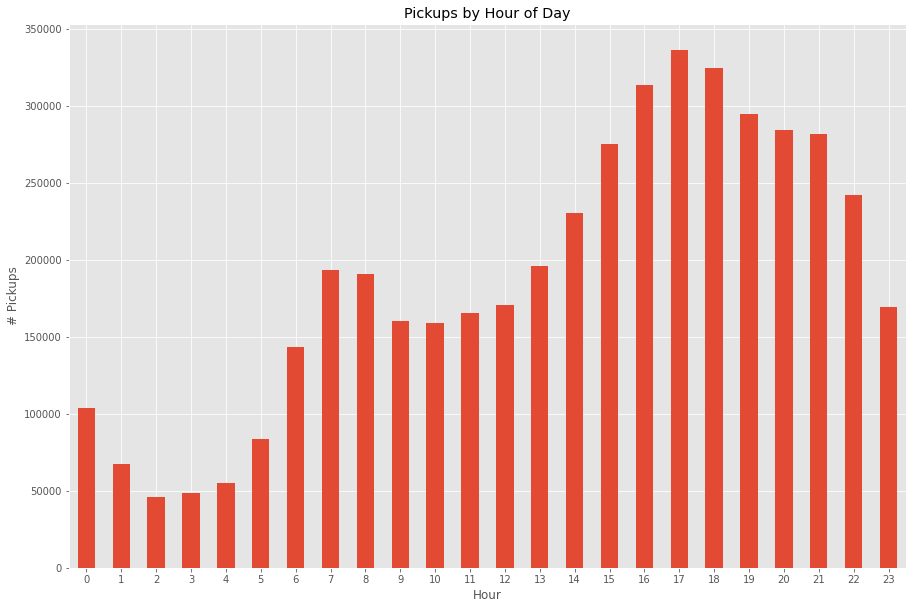

In [17]:
hourly_pickups = pickups['Hour'].value_counts().sort_index()

hourly_pickups.plot(kind='bar', rot=0)
plt.xlabel('Hour')
plt.ylabel('# Pickups')
plt.title('Pickups by Hour of Day');

The hourly distribution of pickups during the 6-month period reveals a multimodal distribution. We see two peaks, one during the morning (7-8 a.m.) and another later in the day (4-6 p.m.). A small peak occurs for very early hours, but this appears to be a downtrend from the previous day as hours are cyclical. Intuitively, these two peaks make sense as they correspond to the times in which individuals go to and return from mandatory destinations such as work.

This may lead one to wonder if the hourly distribution of pickups varies across the 6 months or during different weekdays -- let's explore this.

In [18]:
def plot_subplots(pickups, var_name, var_values, figsize, dim):
    """
    Helper function
    
    Plots subplots for a given variable (Month, Weekday) by Hour
    
    :param pickups: DataFrame containing Uber pickups
    :param var_name: Name of the variable in 'pickups'
    :param var_values: List of variable values
    :param figsize: Tuple contianing figure size
    :param dim: List containing the dimension of subplots
    """
    
    # Figure layout
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    
    # Generate plot
    plot_num = 1
    for value in var_values:
        ax = fig.add_subplot(dim[0], dim[1], plot_num)
        value_df = pickups[pickups[var_name] == value]
        plot = (
            value_df['Hour']
            .value_counts(normalize=True)
            .sort_index()
            .plot(kind='bar', ax=ax, rot=0)
        )
        plt.title(value)
        plt.xlabel('Hour')
        plt.ylabel('Proportion of pickups')
        plot_num +=1

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


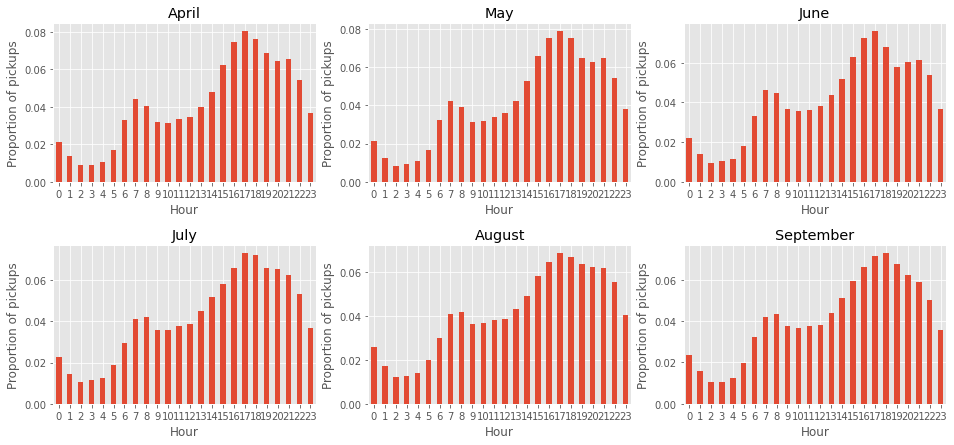

In [19]:
plot_subplots(pickups, 'Month', month_map.values(), (16, 7), [2, 3])

There does appear to be some variability for the hours following 5-6 p.m., as can be seen between the months of June and September. But, overall, it appears that the hourly distributions are relatively consistent across the 6 months. 

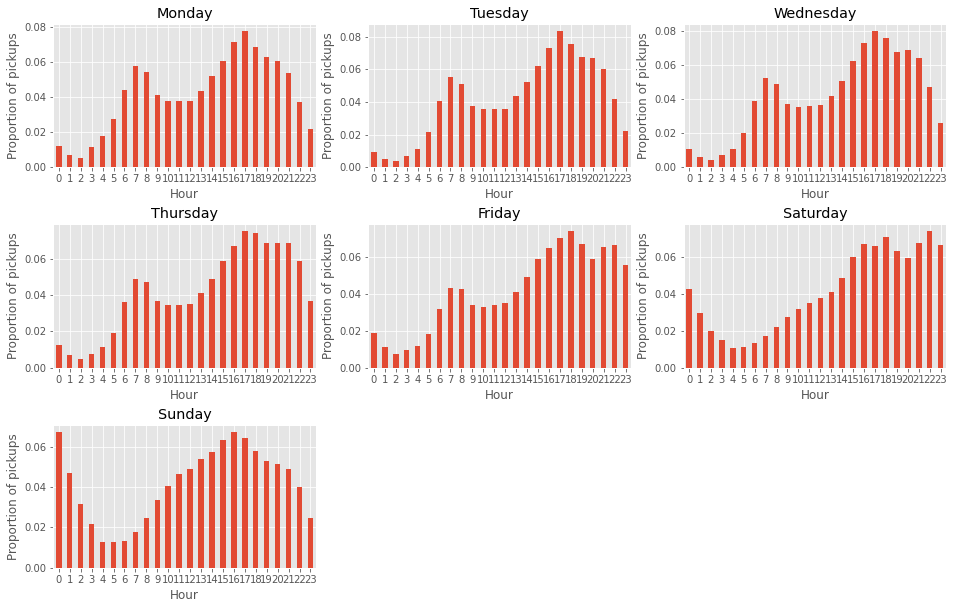

In [20]:
plot_subplots(pickups, 'Weekday', weekday_map.values(), (16, 10), [3, 3])

Exploring hourly distributions by weekday reveals some interesting insight. The Monday-Thursday distributions are very identical but there is a change for the weekdays that follow. Although Friday has an identical distribution earlier in the day, it sees a greater proportion of pickups occurring during later hours (10-11 p.m.). This makes sense, it is Friday night -- many people do not need to make mandatory trips (may not be limited to just work) the next day. 

Now, hourly distributions look very different for Saturday and Sunday. If we look at Saturday, we notice a greater proportion of pickups happening at very early hours of the day (12-2 a.m.), which is surely a result of those late pickups Friday night. Also, Saturday (and Sunday) no longer shows that 7-8 a.m. peak which is expected as people are less likely to get up early in the morning for mandatory purposes. Later that Saturday night, the greatest proportions of late-night Uber pickups occurs and subsequently Sunday sees the greatest proportions of early morning pickups. Sunday then follows a normal-like distribution and those late-night pickups drop significantly as individuals prepare for the new week.

Let's now pay attention to the Bases affiliated with the pickups.

**Uber Pickup Bases**

B02617    0.321735
B02598    0.307237
B02682    0.267468
B02764    0.058200
B02512    0.045359
Name: Base, dtype: float64

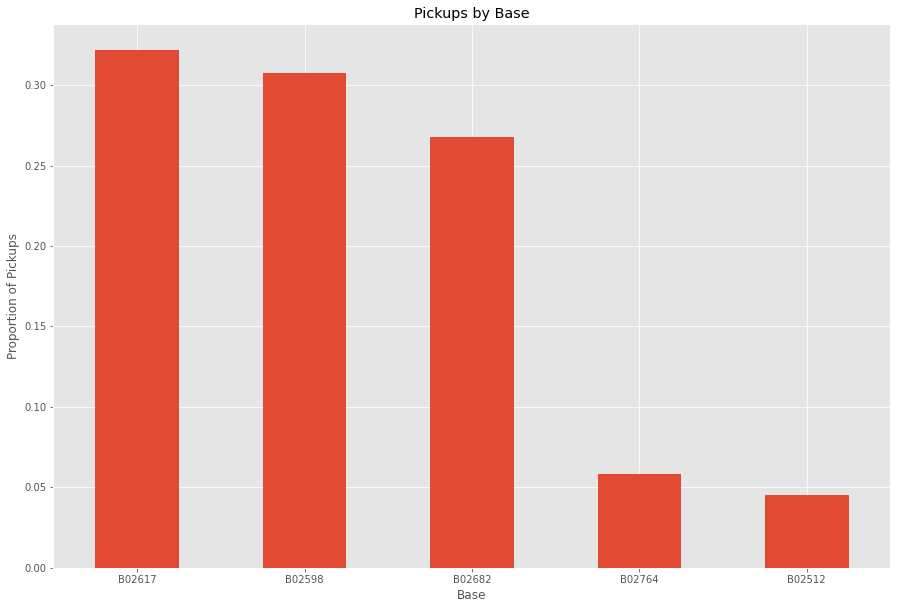

In [21]:
base_props = pickups['Base'].value_counts(normalize=True)
display(base_props)

base_props.plot(kind='bar', rot=0)
plt.xlabel('Base')
plt.ylabel('Proportion of Pickups')
plt.title('Pickups by Base');

We can clearly see an imbalance in pickups between the different bases as nearly 90% of all pickups come from 3 of the 5 bases. Let's determine whether this imbalance holds for different months.

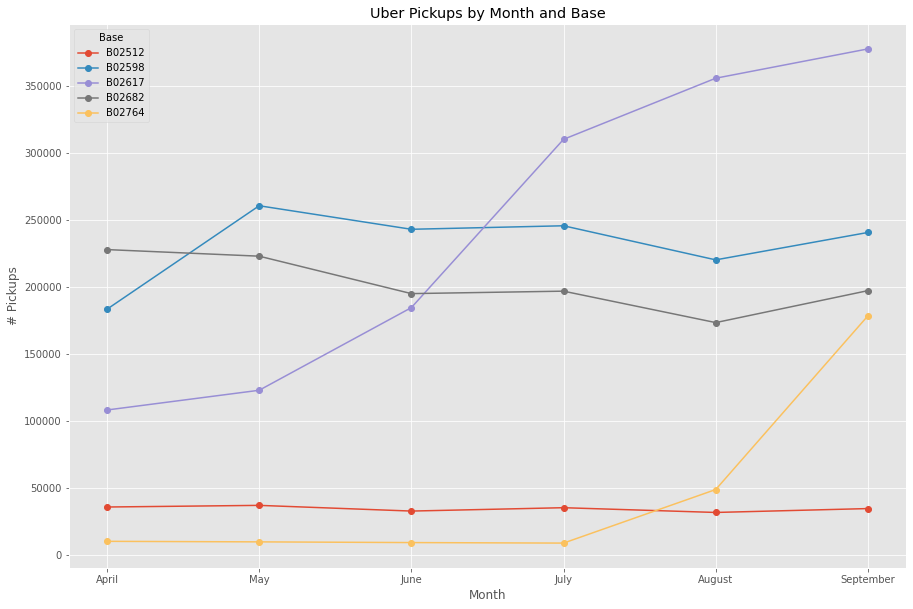

In [22]:
monthly_bases = pickups.groupby('Month')['Base'].value_counts().unstack()

monthly_bases.loc[month_map.values()].plot(kind='line', marker='o', rot=0)
plt.ylabel('# Pickups')
plt.title('Uber Pickups by Month and Base');

When broken down by month, the pickups generated by each base tells a different story. For example, based on the previous plot, Base B02764  makes up a small proportion of pickups (~6%) which may lead one to believe that this base is not very active. However, we can clearly see that its pickup trend over the 6 months is exponential-like (in yellow). If this trend continued, we would expect this base to surpass the others, as was seen with Base B02617 (in purple) in June. It would be interesting to see how these bases compared over the following 6 months.

**Pickup Locations Visualization**

We have now explored and interpreted various aspects of the pickup data. However, we are yet to explore the actual locations of these pickups. Given that we have the latitude and longitude of each pickup, we can do a spatial analysis of the Uber pickups.

Let's take a quick look at where all 4.5 million pickups occurred throughout New York City.

**Note**: In order to determine the locations where pickups were concentrated, pickups that happened in sparse areas were removed (33,455 pickup locations removed).

Number of Pickups: 4500872


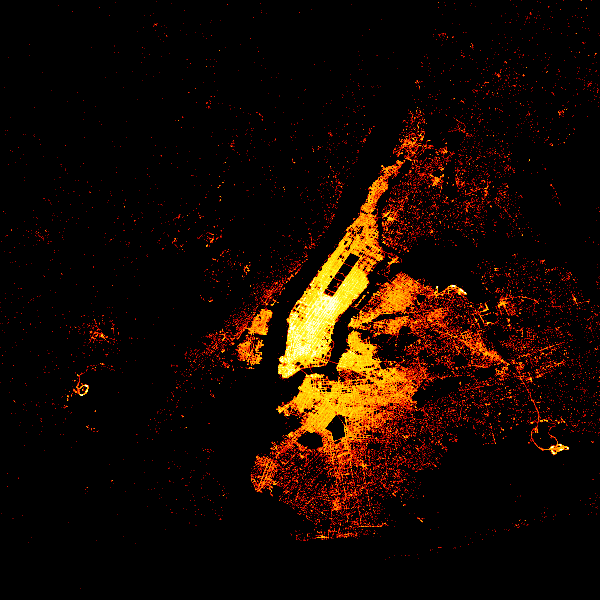

In [23]:
pickups_focused = pickups[
    pickups['Lon'].between(-74.25, -73.75) & 
    pickups['Lat'].between(40.5, 41)
]
print('Number of Pickups: {}'.format(len(pickups_focused)))

pickup_points = ds.Canvas().points(pickups_focused, 'Lon', 'Lat', )
ds.tf.set_background(ds.tf.shade(pickup_points, cmap=cc.fire), "black")

Plotting the pickup locations produces a beautiful outline of different areas in New York City. Right in the center of the plot, we see Manhattan Island where many popular sites reside like Times Square, Broadway, Central Park, etc. Over on the lower right side of the plot, we see a bright spot where JFK airport is located. The fact that pickups are concentrated in these areas is not surprising but is nonetheless very interesting to see.

It would also be neat to produce a time lapse of Uber pickups in New York City over the 6 month period. However, for the sake of time, let's take a look at where pickups occurred for every hour of the day for the busiest day in the data set.

In [24]:
daily_pickup = pickups.groupby(['Month', 'Day'])['Hour'].count()
print('Busiest Day: {}'.format(daily_pickups.idxmax()))
print('Number of pickups: {}'.format(daily_pickups.max()))

Busiest Day: ('September', 13)
Number of pickups: 43205


The busiest day occured on Saturday Septermber 13 with 43,205 pickups -- let's visualize this day.

**Visualizing September 13, 2014**

In [25]:
# Filtering to pickups on September 13
busiest_day = pickups[
    (pickups['Month'] == 'September') & (pickups['Day'] == 13)]

# Extracting all pickups for a given hour
hourly = defaultdict(list)
for pickup in busiest_day.itertuples():
    pickup_time = datetime.strptime(
        '2014-9-13  {}'.format(pickup.Hour), '%Y-%m-%d %H')
    hourly[str(pickup_time)].append([pickup.Lat, pickup.Lon])   
hourly = OrderedDict(sorted(hourly.items(), key=lambda t: t[0]))

In [26]:
mean_location = [pickups['Lat'].mean(),pickups['Lon'].mean()]
pickup_map = folium.Map(mean_location, zoom_start=12, tiles="Stamen Terrain")

hourly_pickups = HeatMapWithTime(
    data=list(hourly.values()),
    index=list(hourly.keys()), 
    radius=10,
    auto_play=True,
    max_opacity=0.4
)
hourly_pickups.add_to(pickup_map)
pickup_map

**Note**: To restart the animation, drag the slider to the left and resume.

The concentration of Uber pickups is consistent with the previous plot. Additionally, the visualization is consistent with our previous findings; very early Saturdays see high levels of pickups (possibly due to Friday night), pickups then die down and pick up steadily into Saturday night.

## Takeaways

This analysis has provided much insight into the New York City Uber pickups in 2014. Some of the key findings include:

- **Heavy increase in pickups during the month of September**
- **Reductions in pickups during holidays**
- **Clear difference in the distribution of hourly pickups between workdays and weekends**
- **Misbalance in pickups between TLC bases**
- **Concentration of pickups in Manhattan Island and surrounding areas**